In [26]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
import torch

from calibration import data
from calibration import dist
from calibration import method
from calibration import pit
from calibration import plot

## Data sets

In [2]:
BINS = 20
SAMPLES = 10000

In [4]:
TESTS = 1000
torch.manual_seed(78)
testset = pit.PITDataset(TESTS, BINS, samples=SAMPLES)

In [5]:
refset = pit.PITReference(BINS)
len(refset)

625

## Mixture density network

In [49]:
checkpoint = torch.load("models/skilled-monkey-956.pt")
hyperparams = checkpoint["hyperparams"]
model = method.MDN(inputs=hyperparams["bins"],
                neurons=hyperparams["neurons"],
                m=hyperparams["m"])
model.load_state_dict(checkpoint["model_state_dict"])
y_mdn = model.predict(testset.X)
model

MDN(
  (linear1): Linear(in_features=20, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=15, bias=True)
)

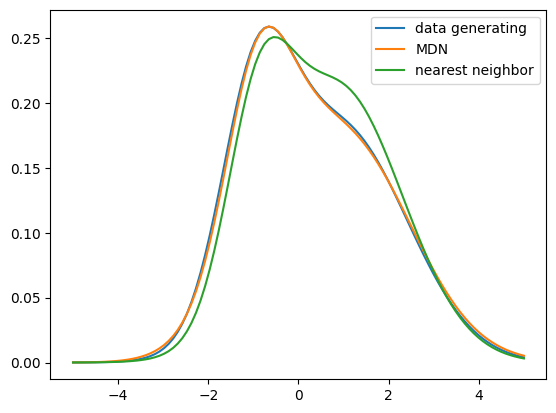

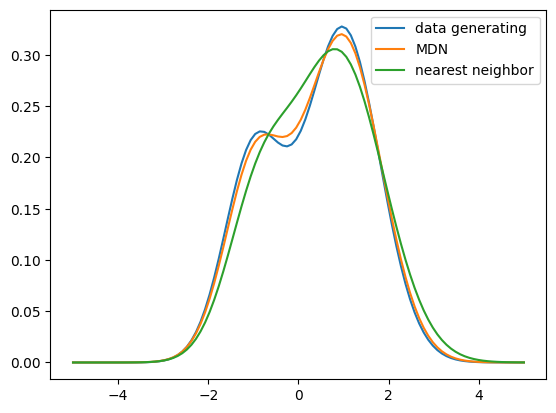

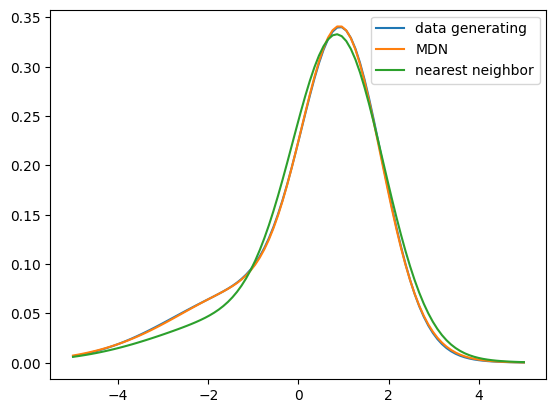

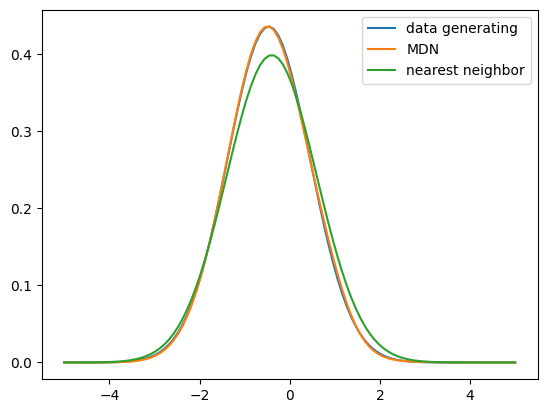

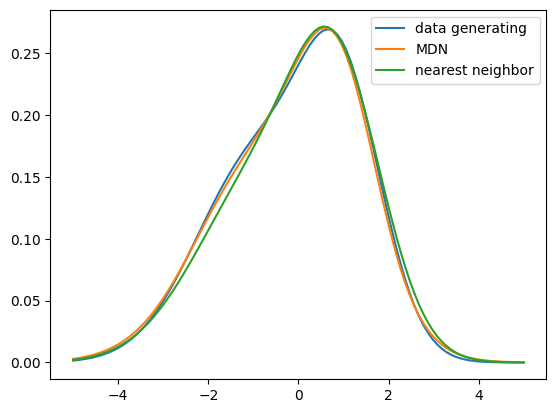

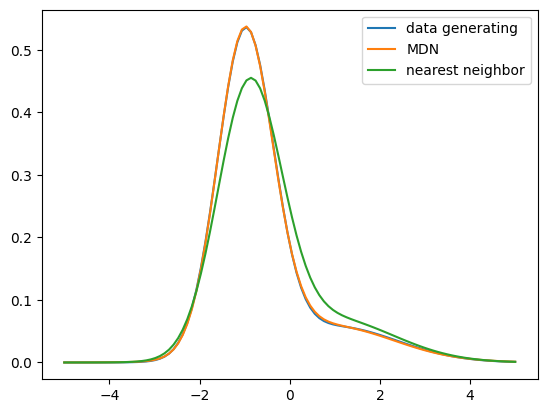

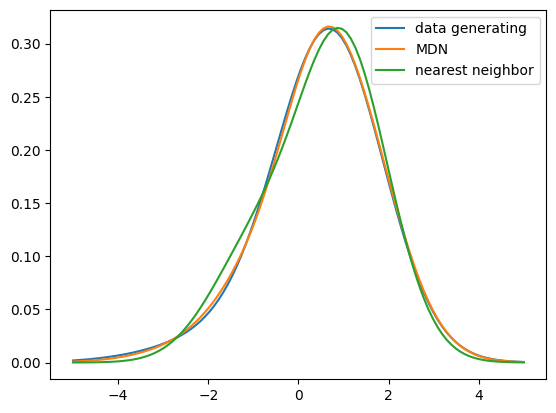

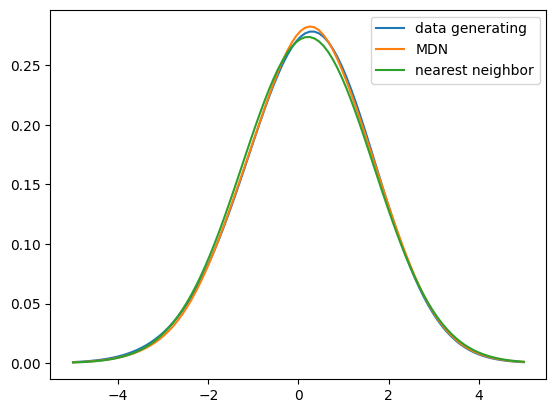

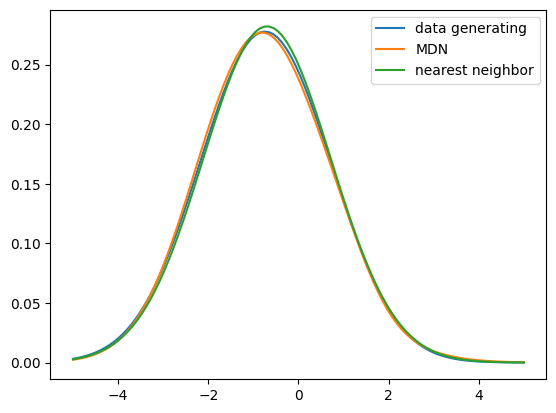

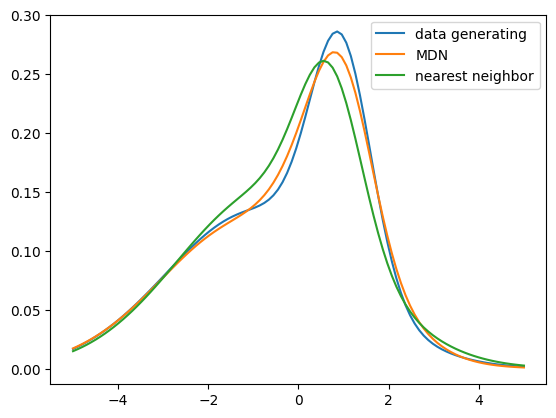

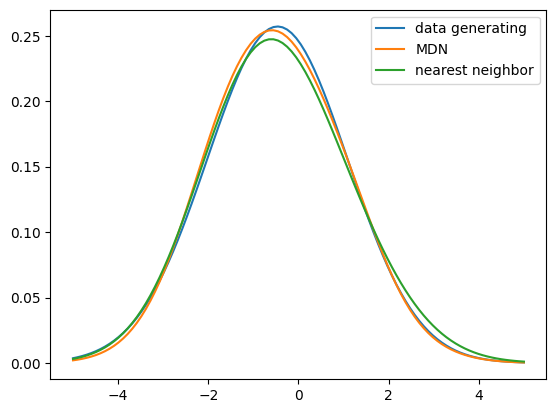

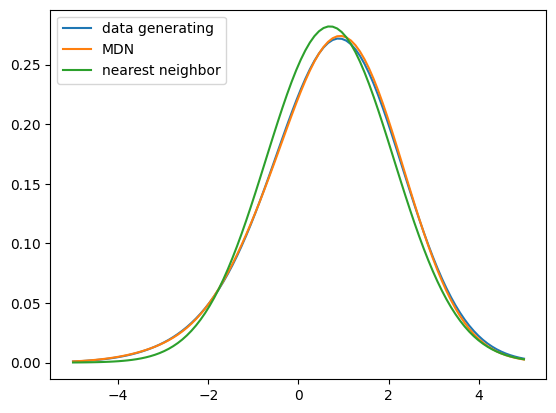

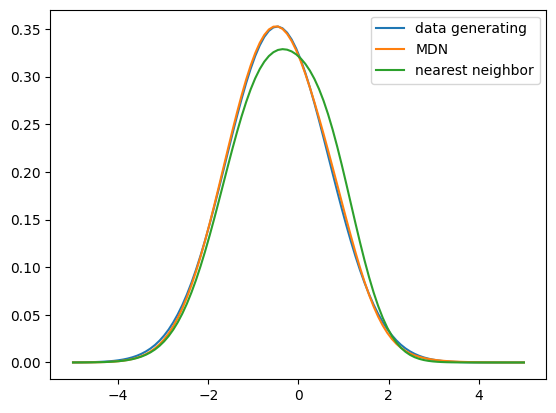

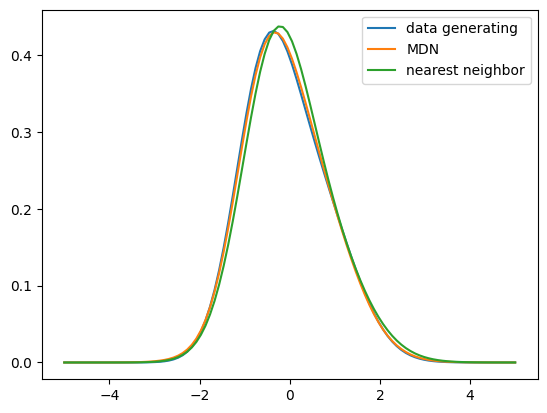

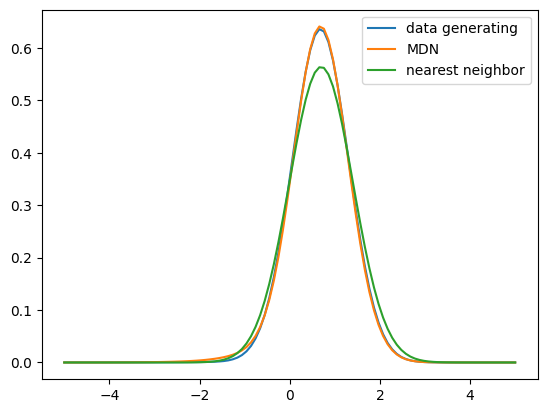

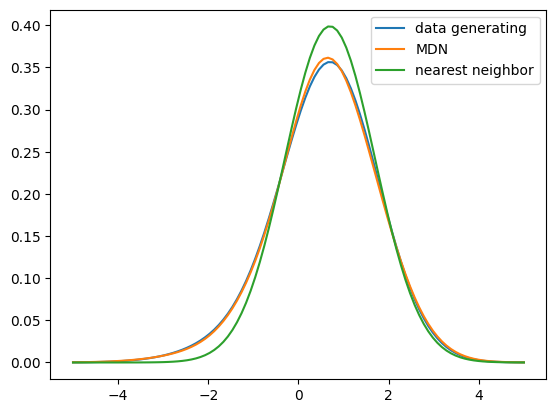

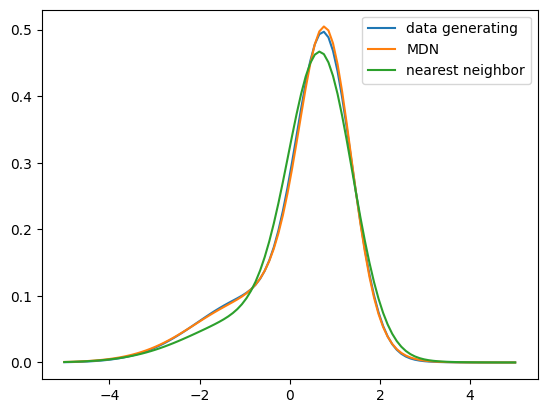

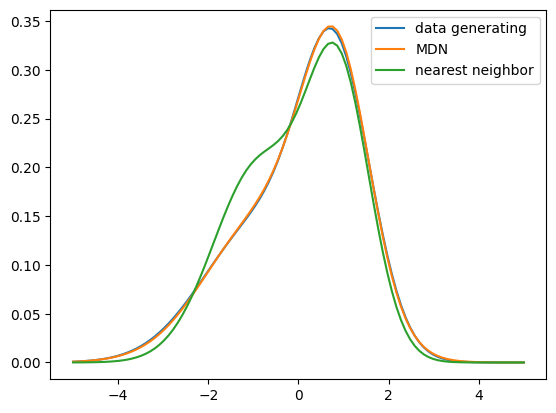

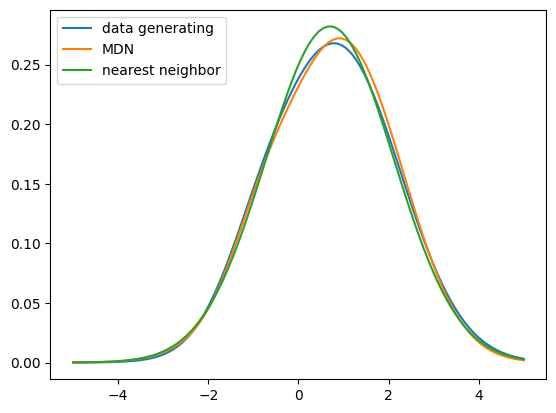

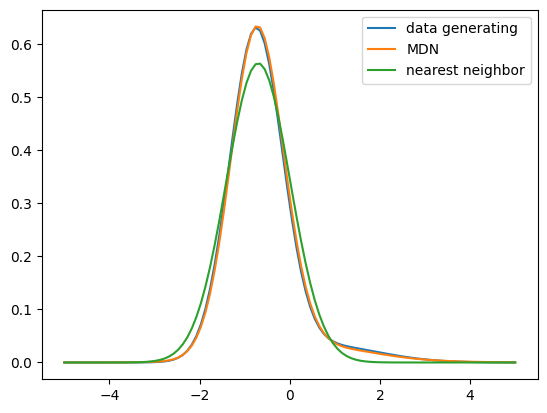

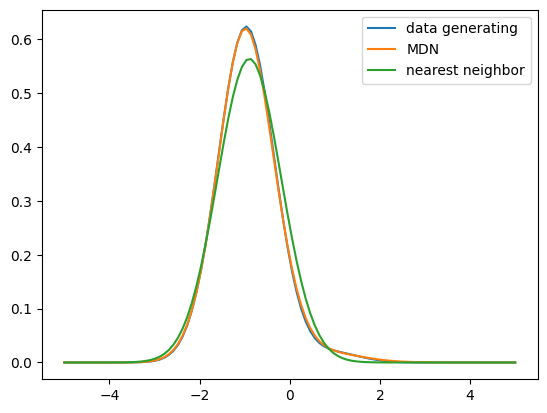

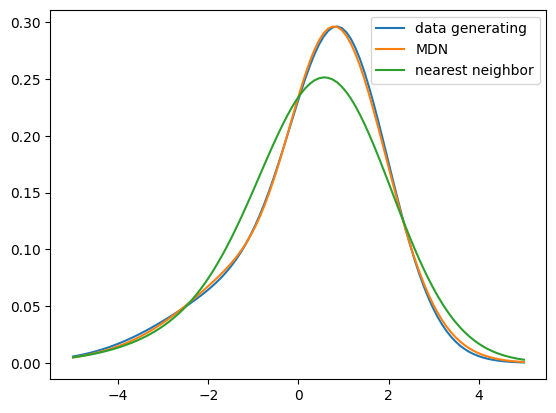

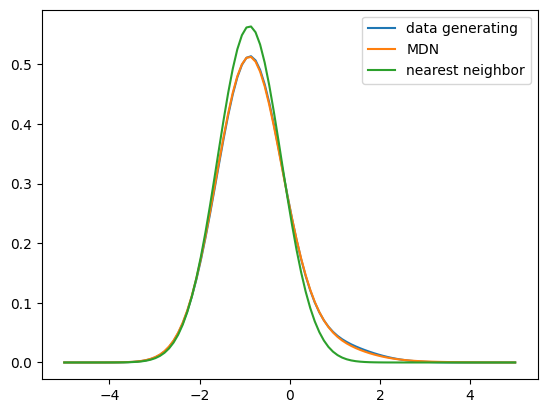

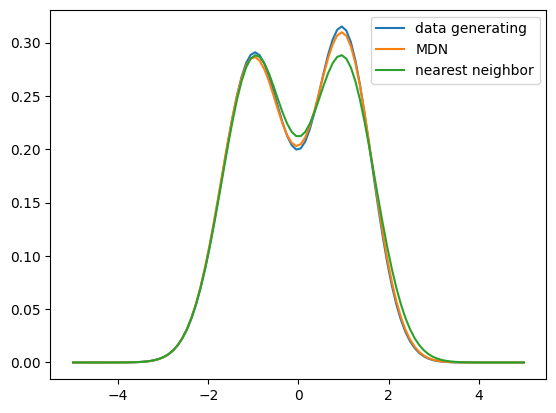

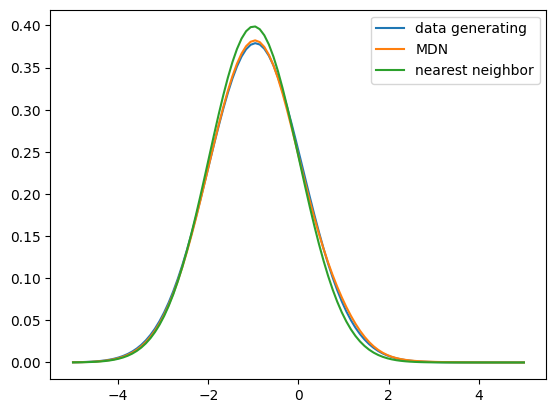

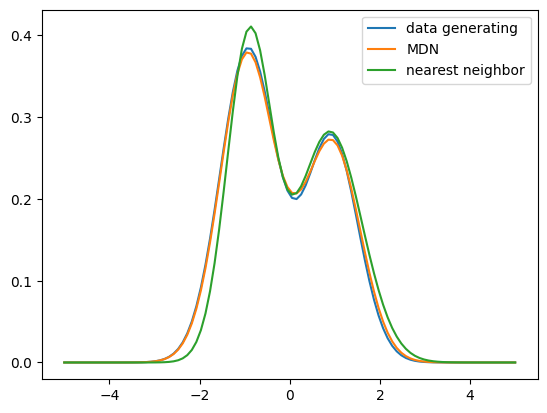

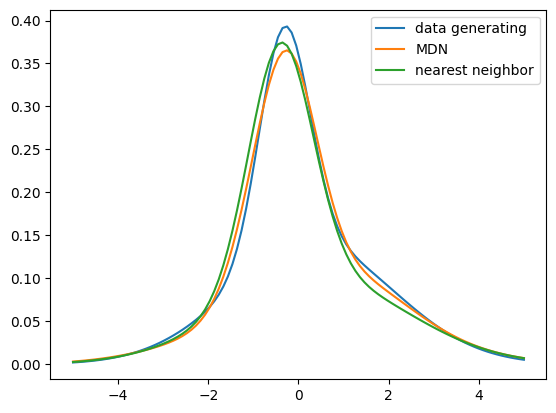

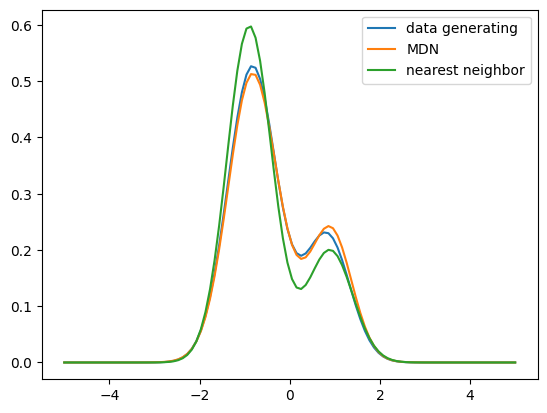

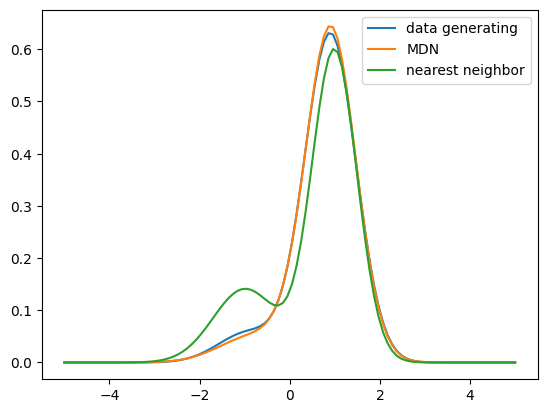

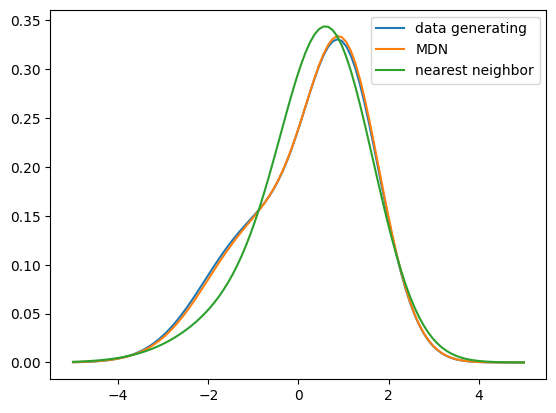

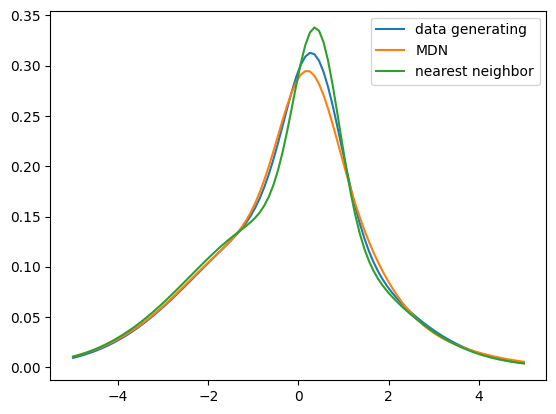

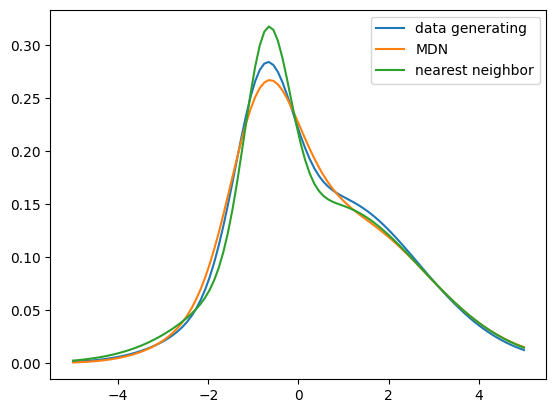

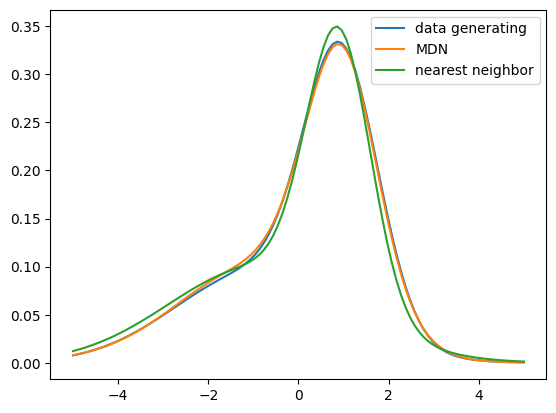

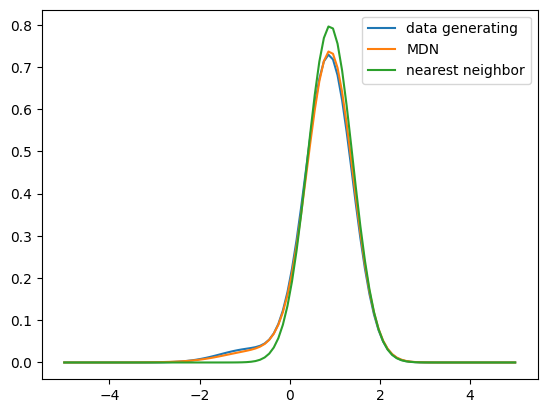

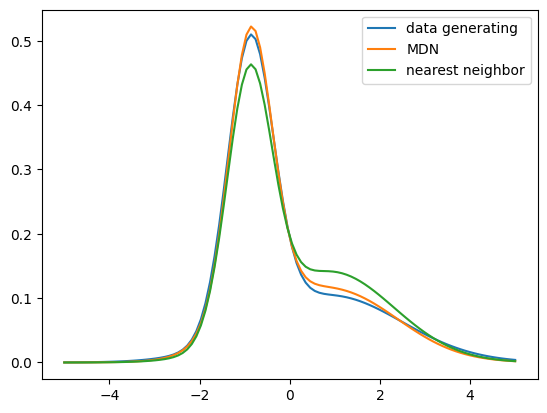

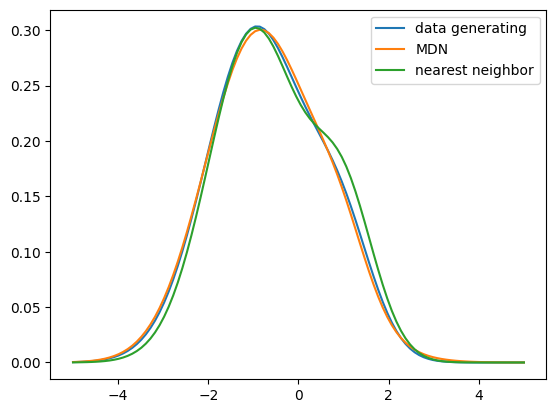

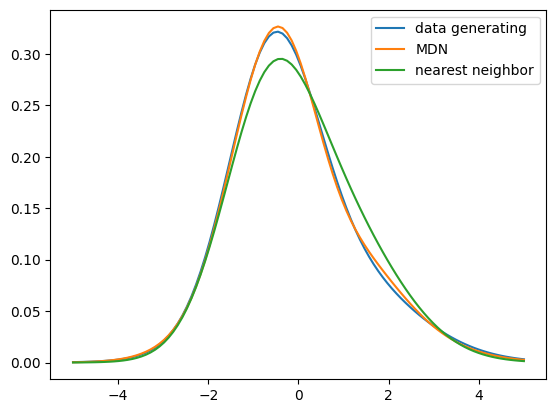

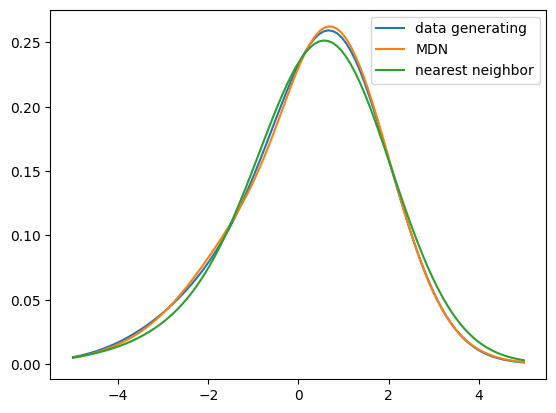

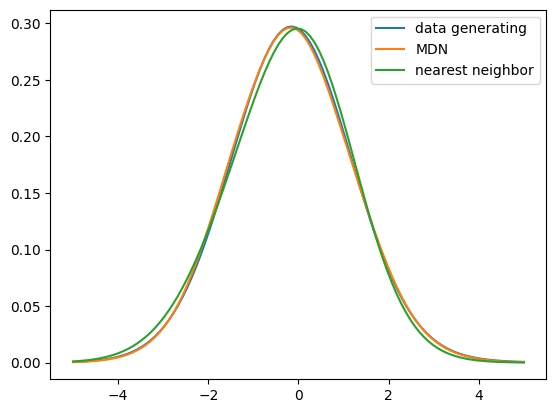

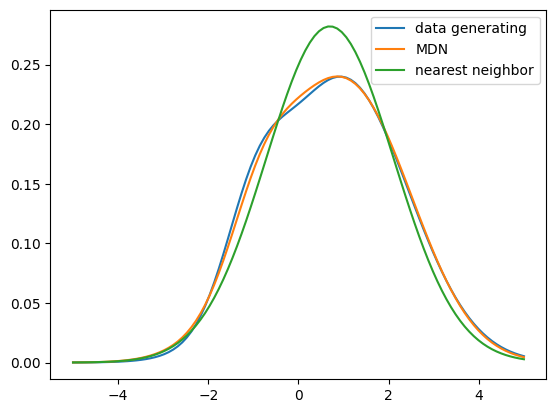

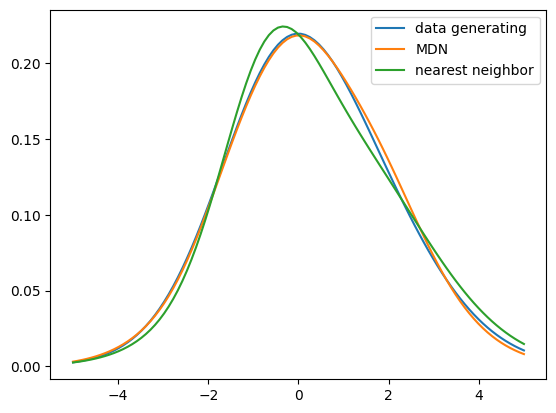

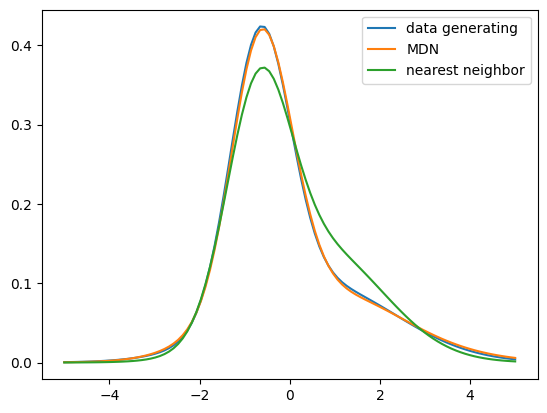

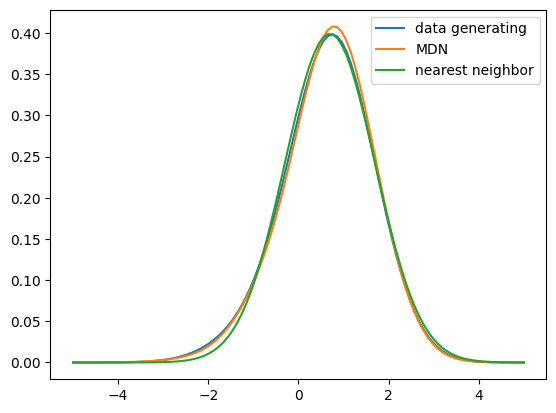

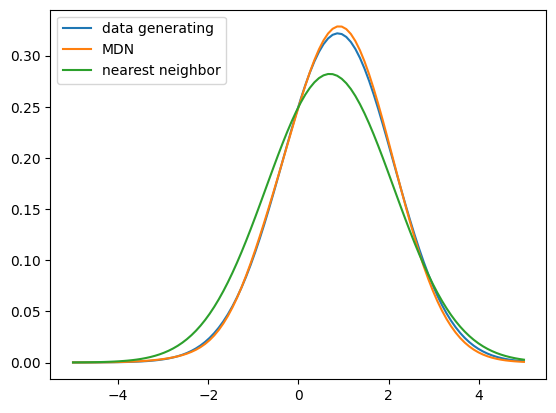

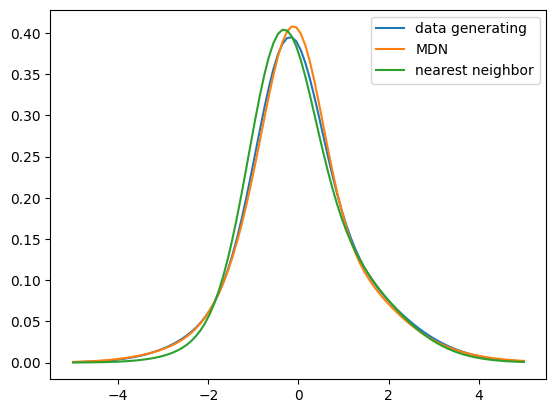

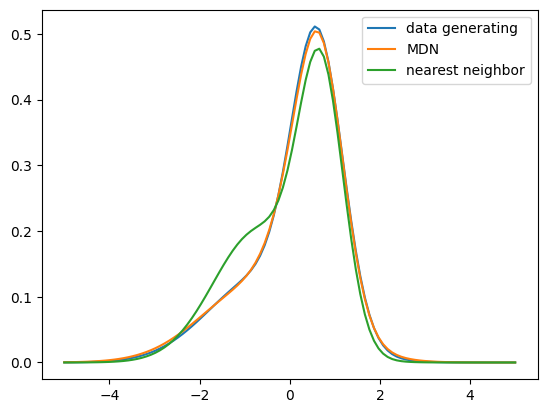

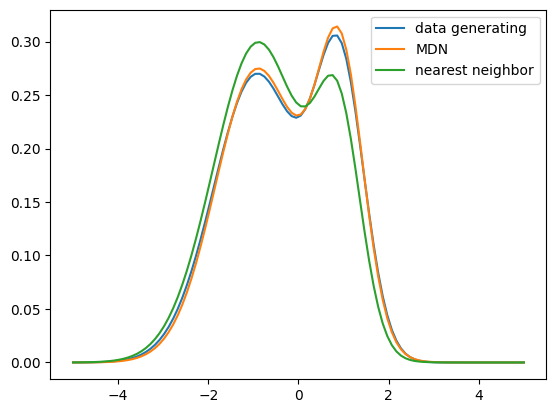

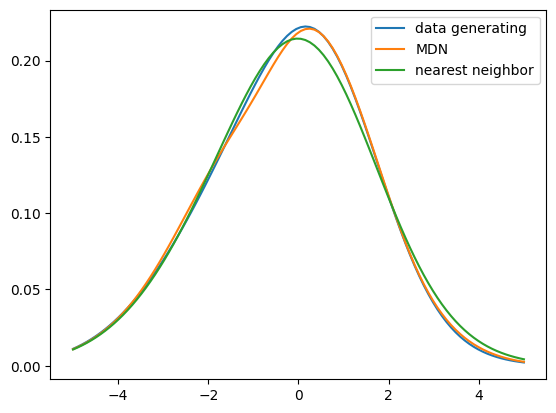

KeyboardInterrupt: 

In [15]:
distances = euclidean_distances(testset.X, refset.X)
js = distances.argmin(axis=1)
for y, alpha, mu, sigma, neighbour in zip(testset.annotation,
                                          *y_mdn,
                                          refset.annotation[js]):
    _, ax = plt.subplots()
    plot.pdf(ax, pit.y2dist(*y), label="data generating")
    plot.pdf(ax, method.params2dist(alpha, mu, sigma), label="MDN")
    plot.pdf(ax, pit.y2dist(*neighbour), label="nearest neighbor")
    ax.legend()
    plt.show()
    plt.close()

In [17]:
nll_mdn = dist.nll_gaussian_mixture(*y_mdn, testset.y).mean()
nll_mdn.item()

1.5748628377914429

In [22]:
steps = range(5, 18)
nll_neighbour = []
for s in steps:
    refset = pit.PITReference(BINS, steps=s)
    distances = euclidean_distances(testset.X, refset.X)
    js = distances.argmin(axis=1)
    neighbour = refset.annotation[js]
    weight = torch.stack([neighbour[:, 0], 1 - neighbour[:, 0]], dim=1)
    mean = torch.stack((-neighbour[:, 1] / 2, neighbour[:, 1] / 2), dim=1)
    variance = neighbour[:, 2:]
    nll = dist.nll_gaussian_mixture(weight, mean, variance, testset.y)
    nll_neighbour.append(nll.mean().item())
    print(f"{s:2d} {nll_neighbour[-1]:f} {s ** 4}")

_, ax = plt.subplots()
size = [s ** 4 for s in steps]
ax.scatter(size, nll_neighbour, label="$k$-NN")
ax.axhline(nll_mdn, label="our MDN")
ax.set_xlabel("size of reference set")
ax.set_ylabel("NLL")
ax.legend()
nll_neighbour

 5 1.594536 625
 6 1.588767 1296
 7 1.584327 2401


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame.from_dict({"steps": steps,
                             "size": size,
                             "nll": nll_neighbour})
df = df.set_index("steps")
df.to_csv("data/neighbour.csv")
df

## Uniform PIT histogram

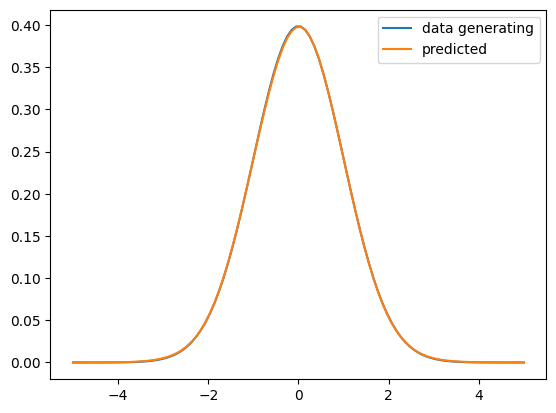

In [24]:
pit_hist_uniform = torch.full((BINS, ), 1 / BINS)
alpha_uniform, mu_uniform, sigma_uniform = model.predict(pit_hist_uniform)
dist_uniform = method.params2dist(alpha_uniform, mu_uniform, sigma_uniform)
_, ax = plt.subplots()
plot.pdf(ax, dist.Gaussian(), label="data generating")
plot.pdf(ax, dist_uniform, label="predicted")
ax.legend()

## Physicochemical Properties of Protein Tertiary Structure

In [27]:
X_train, y_train = data.protein()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train, test_size=0.1, random_state=33)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, test_size=0.1, random_state=79)
X_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
X_train, y_train = X_scaler.fit_transform(X_train), y_scaler.fit_transform(y_train)
X_valid, y_valid = X_scaler.transform(X_valid), y_scaler.transform(y_valid)
X_train, y_train = data.array2tensor(X_train), data.array2tensor(X_valid)
X_valid, y_valid = data.array2tensor(X_valid), data.array2tensor(y_valid)

In [31]:
X_train.shape

torch.Size([37041, 9])

In [34]:
checkpoint = torch.load("models/golden-violet-32.pt")
hyperparams = checkpoint["hyperparams"]
dn_protein = method.MDN(inputs=9,
                        neurons=hyperparams["neurons"],
                        m=1)
dn_protein.load_state_dict(checkpoint["model_state_dict"])
dn_protein

MDN(
  (linear1): Linear(in_features=9, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [ ]:
_, mu, s2 = dn_protein.predict(X_valid)
pit_values = pit.pit(dist.Gaussian(mu, s2), y_valid)
pit_hist_protein = pit.pit_hist(pit_values, BINS)

In [52]:
alpha_protein, mu_protein, simga_protein = model.predict(pit_hist_protein)

In [54]:
sample = dist.sample_gaussian_mixture(alpha_protein, mu_protein, simga_protein, 10000)
pit_values = pit.pit(dist.Gaussian(), sample)
pit_hist = pit.pit_hist(pit_values, BINS)

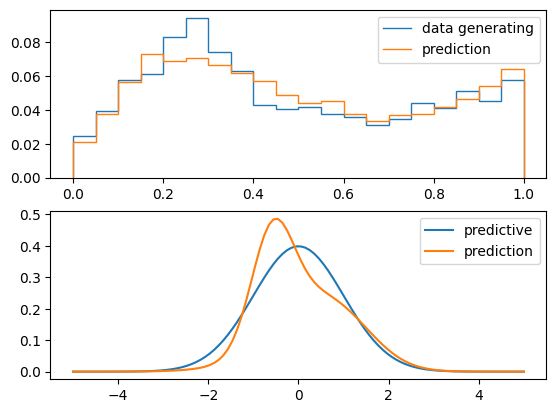

In [56]:
_, (ax1, ax2) = plt.subplots(nrows=2)
plot.pit_hist(ax1, pit_hist_protein, BINS, label="data generating")
plot.pit_hist(ax1, pit_hist, BINS, label="prediction")
ax1.legend()
plot.pdf(ax2, dist.Gaussian(), label="predictive")
plot.pdf(ax2, method.params2dist(alpha_protein, mu_protein, simga_protein), label="prediction")
ax2.legend()

In [88]:
checkpoint = torch.load("models/effortless-blaze-31.pt")
hyperparams = checkpoint["hyperparams"]
mdn_protein = method.MDN(inputs=9, neurons=hyperparams["neurons"], m=2)
mdn_protein.load_state_dict(checkpoint["model_state_dict"])
mdn_protein

MDN(
  (linear1): Linear(in_features=9, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=6, bias=True)
)

In [89]:
alpha, mu, s2 = mdn_protein.predict(X_valid)

In [72]:
import math

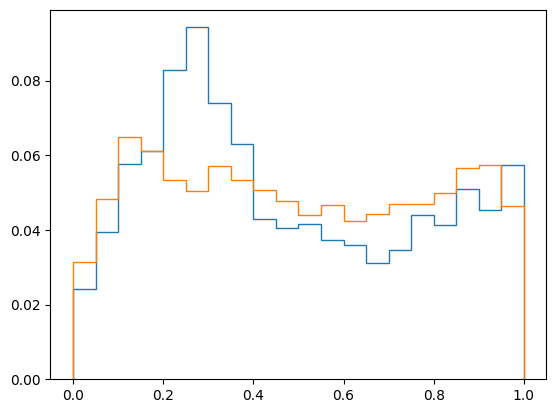

In [90]:
def normal_cdf(x, mean, variance):
    return 0.5 + 0.5 * torch.erf((x - mean) / (torch.sqrt(variance) * math.sqrt(2.0)))

def gmm_pit(coeffs, means, variances, y):
    return torch.sum(coeffs * normal_cdf(y, means, variances), dim=-1, keepdim=True)

pit_values = gmm_pit(alpha, mu, s2, y_valid)
pit_hist = pit.pit_hist(pit_values, BINS)
_, ax = plt.subplots()
plot.pit_hist(ax, pit_hist_protein, BINS)
plot.pit_hist(ax, pit_hist, BINS)